✅ Dataset loaded successfully!
Dataset shape: (361578, 18)
Shape after dropping missing values: (144724, 2)

Category distribution:
 target
0    59804
1    31732
3    12617
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Training Linear SVM...
Accuracy: 0.9020

Classification Report:
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.93      0.92      0.92     11961
                                                             Debt collection       0.86      0.86      0.86      6347
                                                                    Mortgage       0.90      0.93      0.91      2523

                                                                    accuracy                           0.90     20831
                                                                   macro avg       0.89      0.90      0.90     20831
                                                                weighted avg       0.90      0.90      0.90     20831



/tmp/ipython-input-2869304657.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


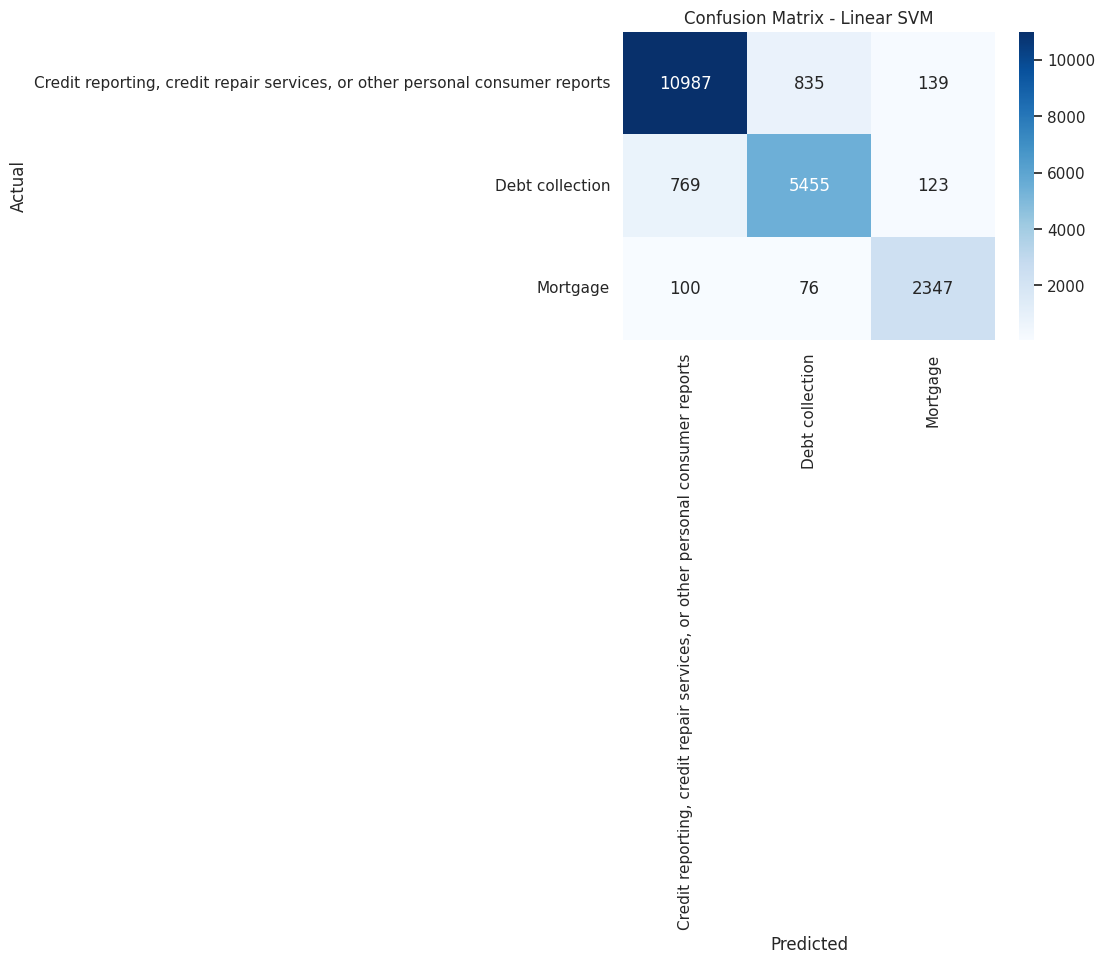


Training Multinomial NB...
Accuracy: 0.8750

Classification Report:
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.90      0.91      0.90     11961
                                                             Debt collection       0.85      0.79      0.82      6347
                                                                    Mortgage       0.83      0.95      0.88      2523

                                                                    accuracy                           0.87     20831
                                                                   macro avg       0.86      0.88      0.87     20831
                                                                weighted avg       0.88      0.87      0.87     20831



/tmp/ipython-input-2869304657.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


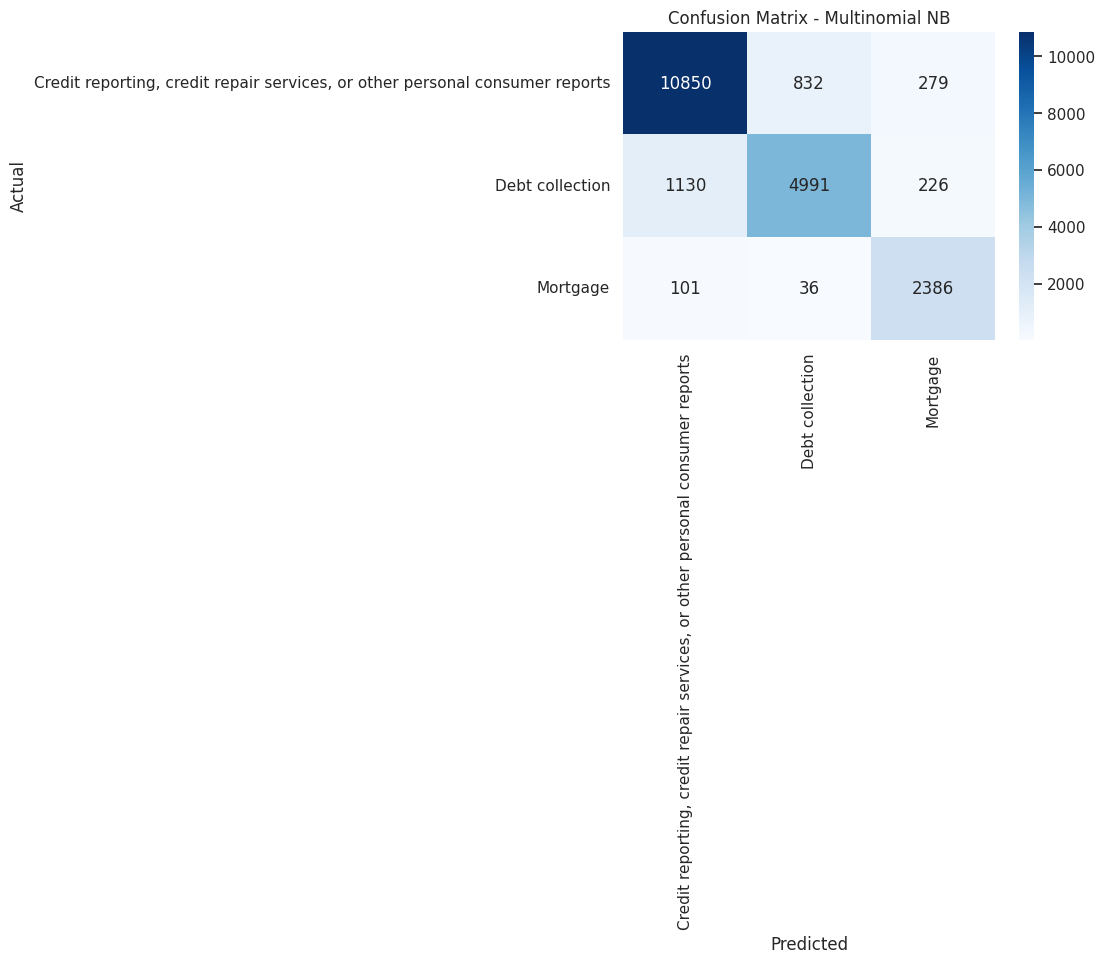


Training Logistic Regression...
Accuracy: 0.8964

Classification Report:
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.94      0.89      0.92     11961
                                                             Debt collection       0.83      0.88      0.86      6347
                                                                    Mortgage       0.87      0.96      0.91      2523

                                                                    accuracy                           0.90     20831
                                                                   macro avg       0.88      0.91      0.89     20831
                                                                weighted avg       0.90      0.90      0.90     20831



/tmp/ipython-input-2869304657.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


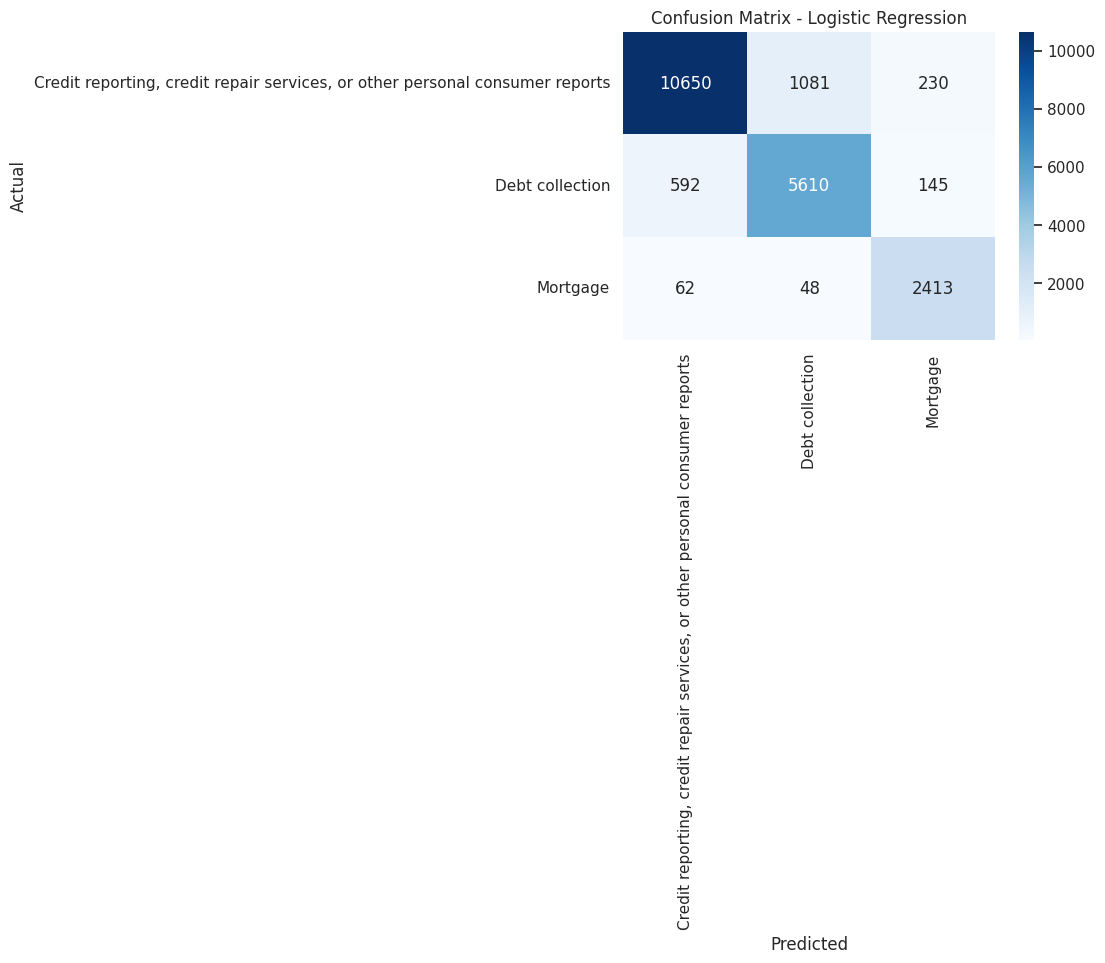


Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:20:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9024

Classification Report:
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.91      0.93      0.92     11961
                                                             Debt collection       0.87      0.84      0.86      6347
                                                                    Mortgage       0.94      0.90      0.92      2523

                                                                    accuracy                           0.90     20831
                                                                   macro avg       0.91      0.89      0.90     20831
                                                                weighted avg       0.90      0.90      0.90     20831



/tmp/ipython-input-2869304657.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


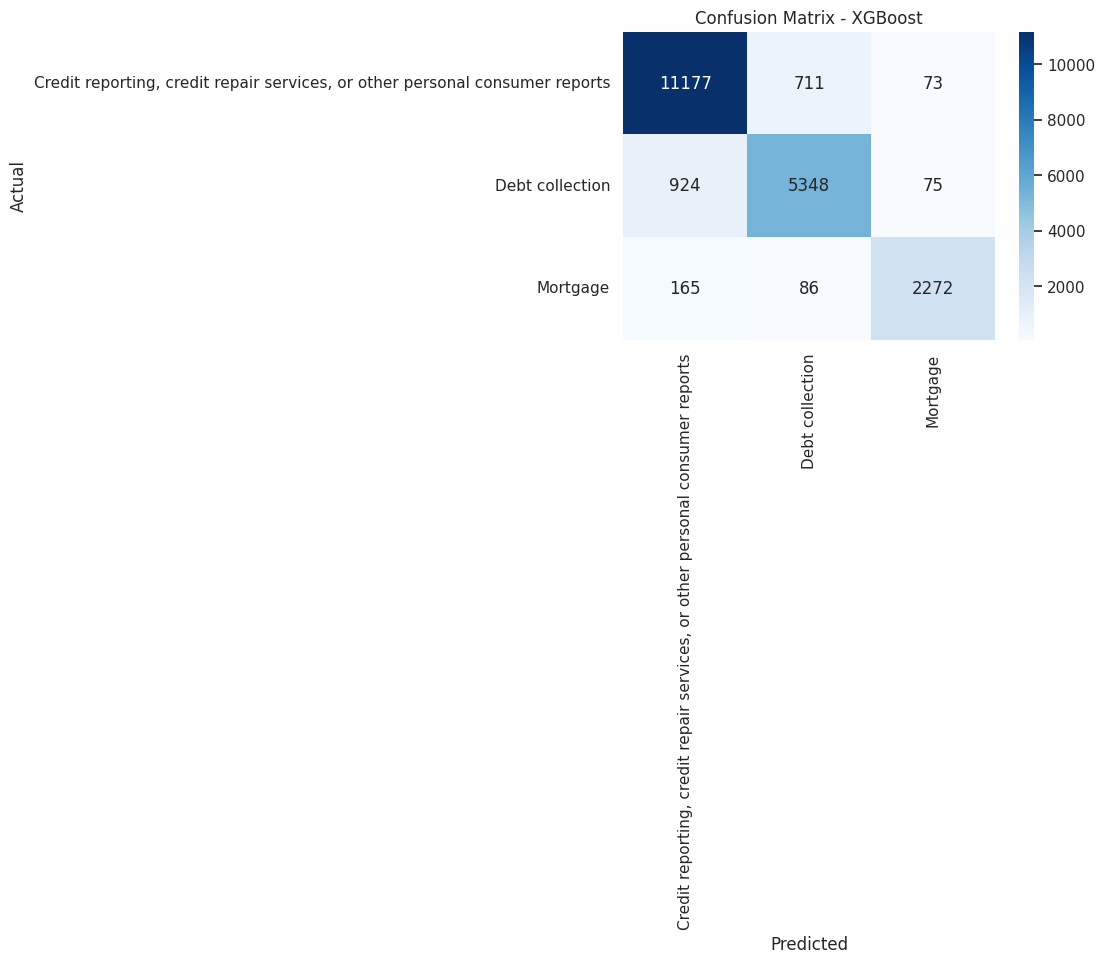

/tmp/ipython-input-2869304657.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


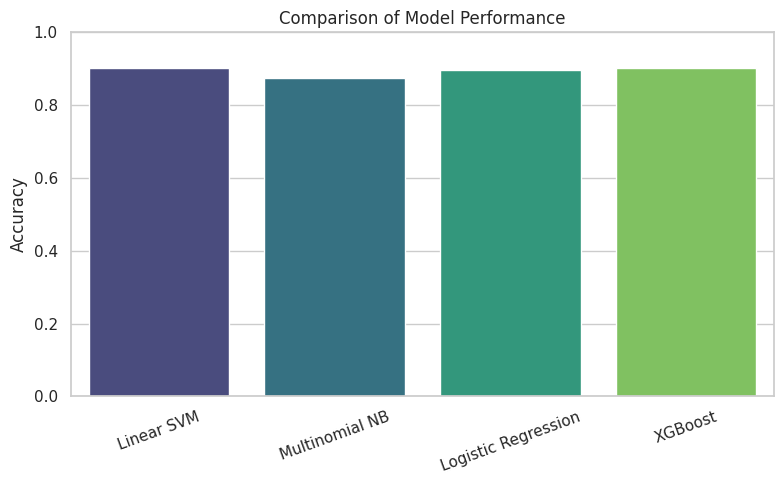


Sample Complaint: I was denied a mortgage modification even though I submitted all documents.
Predicted Category by XGBoost: Mortgage


In [ ]:
# ==========================================
# Consumer Complaint Text Classification
# ==========================================

# Install required packages first if needed:
# pip install pandas matplotlib seaborn nltk scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

sns.set(style="whitegrid")

# ==========================================
# Step 1: Load Dataset Safely
# ==========================================
file_path = "rows.csv"  # replace with your local CSV path
df = pd.read_csv(file_path, on_bad_lines="skip", engine="python")
print("✅ Dataset loaded successfully!")
print("Dataset shape:", df.shape)

# Keep relevant columns and drop missing complaints
df = df[['Consumer complaint narrative', 'Product']].dropna()
df.rename(columns={'Consumer complaint narrative':'complaint', 'Product':'product'}, inplace=True)
print("Shape after dropping missing values:", df.shape)

# ==========================================
# Step 2: Map Target Categories
# ==========================================
mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}

df = df[df['product'].isin(mapping.keys())]
df['target'] = df['product'].map(mapping)
print("\nCategory distribution:\n", df['target'].value_counts())

# ==========================================
# Step 3: Text Preprocessing
# ==========================================
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['complaint'].apply(preprocess_text)

# ==========================================
# Step 4: Train-Test Split
# ==========================================
X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==========================================
# Step 5: TF-IDF Vectorization
# ==========================================
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ==========================================
# Step 6: Train Multiple Models
# ==========================================
models = {
    'Linear SVM': LinearSVC(class_weight='balanced', random_state=42),
    'Multinomial NB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # XGBoost requires contiguous integer labels
    if name == "XGBoost":
        present_classes = sorted(y_train.unique())
        class_remap = {old: new for new, old in enumerate(present_classes)}
        y_train_xgb = y_train.map(class_remap)
        y_test_xgb = y_test.map(class_remap)
        model.fit(X_train_vec, y_train_xgb)
        y_pred_xgb = model.predict(X_test_vec)
        # Map back to original labels
        reverse_class_remap = {v:k for k,v in class_remap.items()}
        y_pred = pd.Series(y_pred_xgb).map(reverse_class_remap)
    else:
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Dynamic target names
    present_classes_test = sorted(y_test.unique())
    present_names = [k for k,v in mapping.items() if v in present_classes_test]

    print("\nClassification Report:\n", classification_report(
        y_test, y_pred, labels=present_classes_test, target_names=present_names
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=present_classes_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_names, yticklabels=present_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    results[name] = acc

# ==========================================
# Step 7: Compare Model Performance
# ==========================================
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Performance")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# ==========================================
# Step 8: Prediction Example
# ==========================================
sample_text = "I was denied a mortgage modification even though I submitted all documents."
sample_clean = preprocess_text(sample_text)
sample_vec = vectorizer.transform([sample_clean])

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

# Handle XGBoost remapping for sample
if best_model_name == "XGBoost":
    y_pred_sample = best_model.predict(sample_vec)
    y_pred_sample = pd.Series(y_pred_sample).map(reverse_class_remap)
else:
    y_pred_sample = best_model.predict(sample_vec)

pred_class = y_pred_sample[0]
reverse_mapping = {v:k for k,v in mapping.items()}

print("\nSample Complaint:", sample_text)
print(f"Predicted Category by {best_model_name}:", reverse_mapping[pred_class])
